In [57]:
from typing import Optional
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.logger import configure
from stable_baselines3.common.monitor import Monitor
import torch
from stable_baselines3.common.vec_env import VecNormalize, DummyVecEnv
from sympy.physics.units import velocity


# Define the RL environment
class ColorMatchEnv(gym.Env):
    def __init__(self):
        super(ColorMatchEnv, self).__init__()

        self.velocity = 0
        self.difference = 0
        self.size = 256
        # Action space: Increase or decrease R, G, B
        self.action_space = spaces.Discrete(6)  
        self.observation_space = spaces.Box(low=0, high=self.size, shape=(6,), dtype=np.int16)
    
    
    def step(self, action):
        
        prev_color = self.current_color.copy()
        
        step_size = 1
        if action == 0: self.current_color[0] += step_size  # Increase R
        elif action == 1: self.current_color[0] -= step_size  # Decrease R
        elif action == 2: self.current_color[1] += step_size  # Increase G
        elif action == 3: self.current_color[1] -= step_size  # Decrease G
        elif action == 4: self.current_color[2] += step_size  # Increase B
        elif action == 5: self.current_color[2] -= step_size  # Decrease B

        # Clamp values between 0 and 1
        self.current_color = np.clip(self.current_color, 0, self.size)
        max_distance = np.linalg.norm(np.array([self.size, self.size, self.size]))
        prev_distance = np.linalg.norm(self.target_color - prev_color) / max_distance
        new_distance = np.linalg.norm(self.target_color - self.current_color) / max_distance
        
        reward_r = self.direction_reward(self.current_color[0], self.target_color[0], prev_color[0])
        reward_g = self.direction_reward(self.current_color[1], self.target_color[1], prev_color[1])
        reward_b = self.direction_reward(self.current_color[2], self.target_color[2], prev_color[2])
        reward = (reward_r + reward_g + reward_b) / 3
        # reward = np.sign(prev_distance - new_distance)     
        
        # if prev_distance < new_distance:
        #     reward = -0.5
        # else:
        #     reward = pow(1 - new_distance, 2) * 0.5 #max(0.1, 1 / (1 + new_distance)) 
        
        self.difference = prev_distance - new_distance
        
        # Compute reward (negative Euclidean distance)

        # self.velocity = self.velocity_reward(self.current_color, self.target_color, self.current_color - prev_color)
        
        # Done if very close to target
        done = np.linalg.norm(self.current_color - self.target_color) < 0.01
        truncated = False
        observation = self._get_obs()
        info = self._get_info()
    
        return observation, reward, done.all(), truncated, info
    
    def direction_reward(self, agent_position, target_position, prev_position):
        distance_to_target = np.abs(target_position - agent_position)
        prev_distance = np.abs(target_position - prev_position)
    
        if distance_to_target < 0.1:
            return 1  # Large reward for reaching the goal
    
        if np.abs(agent_position - prev_position) == 0:
            return -0.1  # Small penalty for no movement
    
        if distance_to_target > prev_distance:
            return -0.5  # Mild penalty for moving away
        
        #return 1 - np.abs(target_position - agent_position)
        return 1 / (1 + distance_to_target)  # Reward inversely proportional to distance
    
    def velocity_reward(self, agent_position, target_position, agent_velocity):
        direction_to_target = target_position - agent_position
        direction_to_target /= np.linalg.norm(direction_to_target)  # Normalize direction
        velocity_dot_product = np.dot(agent_velocity, direction_to_target)
        return velocity_dot_product
    
    def smooth_reward(self, agent_position, target_position, agent_velocity, lambda_factor=1):
        # distance = np.linalg.norm(agent_position - target_position)
        distance = 1 - np.linalg.norm(self.target_color - self.current_color)
        distance = pow(distance, 2)
        direction_to_target = target_position - agent_position
        direction_to_target /= np.linalg.norm(direction_to_target)  # Normalize direction
        velocity_dot_product = np.dot(agent_velocity, direction_to_target)
        
        return distance + lambda_factor * velocity_dot_product

    def _get_obs(self):
        return np.concatenate([self.current_color, self.target_color])
    
    def _get_info(self):
        return { "distance" : np.linalg.norm(self.current_color - self.target_color), "velocity" : self.velocity, "difference" : self.difference}
    
    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        self.target_color = self.np_random.integers(0, self.size, size=3) # New target
        self.current_color = self.np_random.integers(0, self.size, size=3)  # Reset color

        observation = self._get_obs()
        info = self._get_info()

        return observation, info

log_dir = "./ppo_logs/"
new_logger = configure(log_dir, ["csv", "tensorboard"])
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.device_count())  # Number of available GPUs
# Train with PPO
env = ColorMatchEnv()
# env = DummyVecEnv([lambda: ColorMatchEnv()])
# env = VecNormalize(env, norm_reward=True)
env = Monitor(env, log_dir)
model = PPO("MlpPolicy", env, verbose=1, clip_range=0.2, device="cpu", learning_rate=0.00002, ent_coef=0.2, gae_lambda=0.99, vf_coef=0.2, n_epochs=5, batch_size=256)
model.set_logger(new_logger)
model.learn(total_timesteps=10000000)

print(torch.cuda.is_available())  # Should return True
print(torch.cuda.device_count())  # Number of available GPUs

False
0
Using cpu device
Wrapping the env in a DummyVecEnv.
False
0


Index(['time/iterations', 'time/total_timesteps', 'time/time_elapsed',
       'time/fps', 'train/policy_gradient_loss', 'train/clip_range',
       'train/loss', 'train/value_loss', 'train/clip_fraction',
       'train/learning_rate', 'train/approx_kl', 'train/entropy_loss',
       'train/n_updates', 'train/explained_variance', 'rollout/ep_len_mean',
       'rollout/ep_rew_mean'],
      dtype='object')


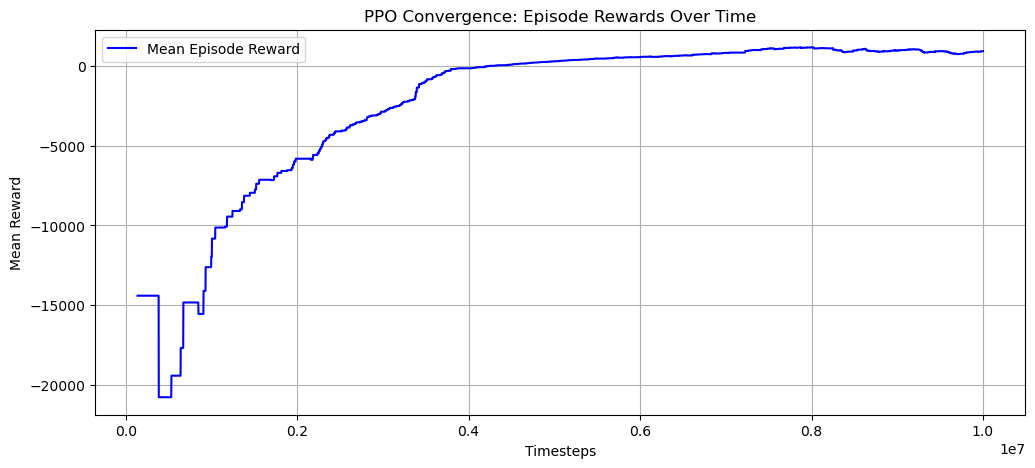

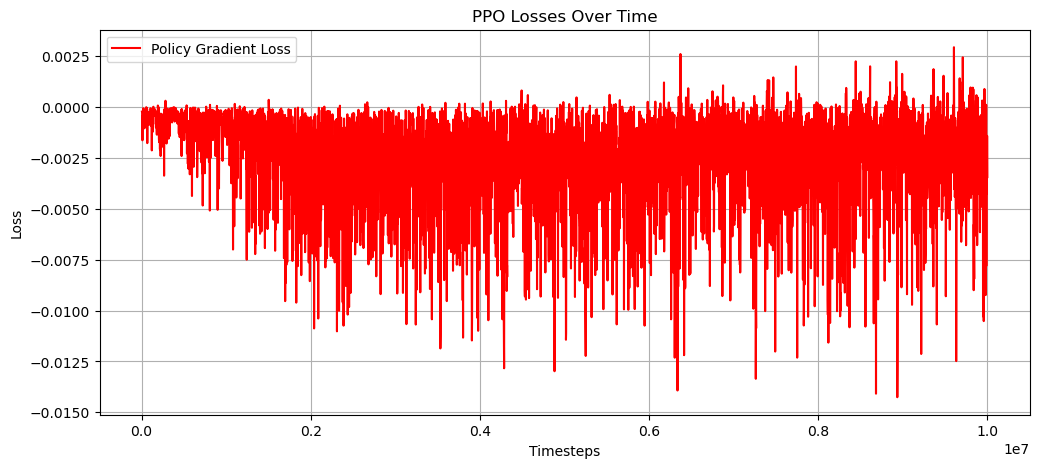

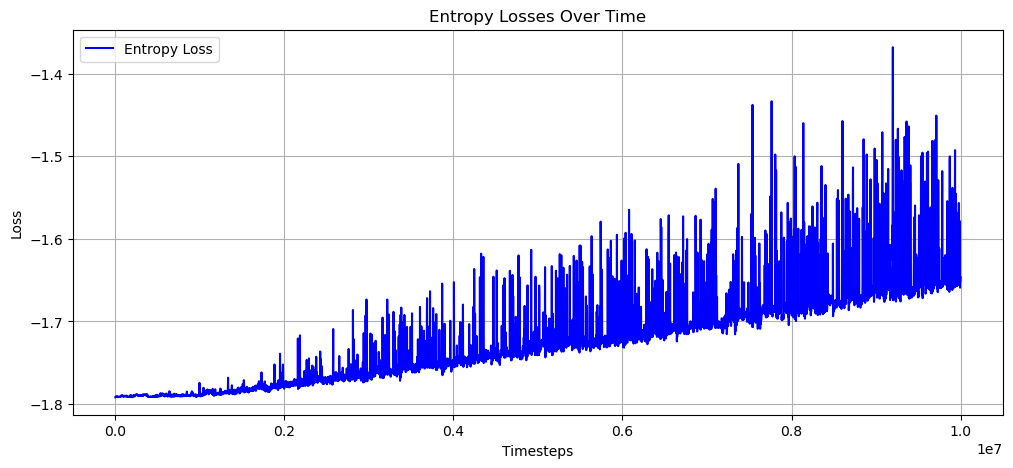

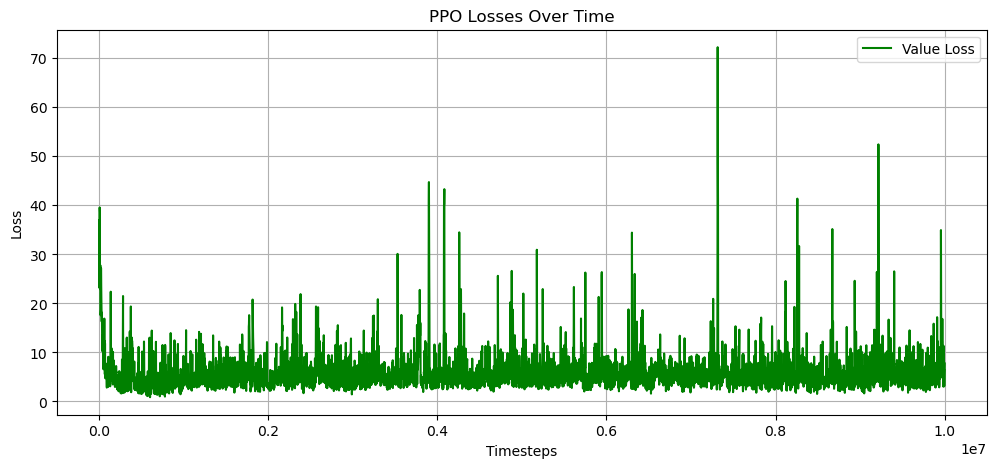

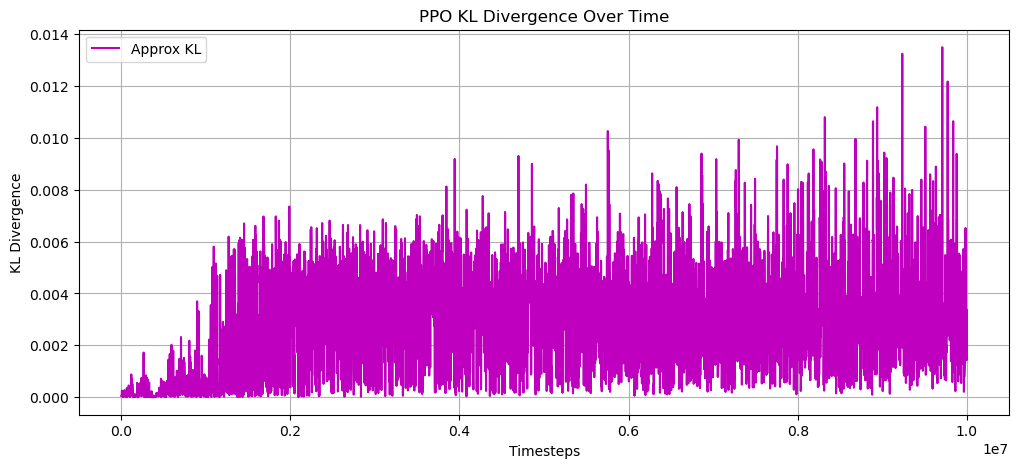

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

# Load PPO logs
log_file = "./ppo_logs/progress.csv"  # Make sure this path matches your logger output
data = pd.read_csv(log_file)
print(data.columns)

# Plot Episode Rewards
plt.figure(figsize=(12, 5))
plt.plot(data["time/total_timesteps"], data["rollout/ep_rew_mean"], label="Mean Episode Reward", color='b')
plt.xlabel("Timesteps")
plt.ylabel("Mean Reward")
plt.title("PPO Convergence: Episode Rewards Over Time")
plt.legend()
plt.grid()
plt.show()

# Plot Losses (Policy Gradient Loss & Value Loss)
plt.figure(figsize=(12, 5))
plt.plot(data["time/total_timesteps"], data["train/policy_gradient_loss"], label="Policy Gradient Loss", color='r')

plt.xlabel("Timesteps")
plt.ylabel("Loss")
plt.title("PPO Losses Over Time")
plt.legend()
plt.grid()
plt.show()

# Plot Losses (Policy Gradient Loss & Value Loss)
plt.figure(figsize=(12, 5))
# plt.plot(data["time/total_timesteps"], data["train/value_loss"], label="Value Loss", color='g')
plt.plot(data["time/total_timesteps"], data["train/entropy_loss"], label="Entropy Loss", color='b')
# plt.plot(data["time/total_timesteps"], data["train/value_loss"], label="Value Loss", color='g')
plt.xlabel("Timesteps")
plt.ylabel("Loss")
plt.title("Entropy Losses Over Time")
plt.legend()
plt.grid()
plt.show()

# Plot Losses (Policy Gradient Loss & Value Loss)
plt.figure(figsize=(12, 5))
# plt.plot(data["time/total_timesteps"], data["train/value_loss"], label="Value Loss", color='g')
# plt.plot(data["time/total_timesteps"], data["train/entropy_loss"], label="Entropy Loss", color='b')
plt.plot(data["time/total_timesteps"], data["train/value_loss"], label="Value Loss", color='g')
plt.xlabel("Timesteps")
plt.ylabel("Loss")
plt.title("PPO Losses Over Time")
plt.legend()
plt.grid()
plt.show()

# Plot KL Divergence (to check stability)
plt.figure(figsize=(12, 5))
plt.plot(data["time/total_timesteps"], data["train/approx_kl"], label="Approx KL", color='m')
plt.xlabel("Timesteps")
plt.ylabel("KL Divergence")
plt.title("PPO KL Divergence Over Time")
plt.legend()
plt.grid()
plt.show()


In [61]:

# Test the trained agent
obs, _ = env.reset()
done = False
count = 0
while not done:
    count+=1
    action, _ = model.predict(obs)
    obs, reward, done, _, infos = env.step(action)
    direction = obs[3:] - obs[:3]
    max_distance = np.linalg.norm(np.array([1, 1, 1]))
    distance = np.linalg.norm(direction) / max_distance
    print(f"Distance {round(distance, 2)} Color: {obs[:3]}, Target: {obs[3:]}, {action} Reward: {round(reward, 2)}")
    # print(f"Distance {round(distance, 2)} Reward: {reward}")
    # print(f"Reward: {reward} Velocity: {round(infos['velocity'], 2)} Difference: {round(infos['difference'], 2)}")

print(f"Done in {count} steps")

Distance 61.51 Color: [219  73 189], Target: [141  10 153], 3 Reward: -0.06
Distance 61.17 Color: [219  72 189], Target: [141  10 153], 3 Reward: -0.06
Distance 60.83 Color: [219  71 189], Target: [141  10 153], 3 Reward: -0.06
Distance 60.5 Color: [219  70 189], Target: [141  10 153], 3 Reward: -0.06
Distance 60.17 Color: [219  69 189], Target: [141  10 153], 3 Reward: -0.06
Distance 59.84 Color: [219  68 189], Target: [141  10 153], 3 Reward: -0.06
Distance 59.52 Color: [219  67 189], Target: [141  10 153], 3 Reward: -0.06
Distance 59.21 Color: [219  66 189], Target: [141  10 153], 3 Reward: -0.06
Distance 58.89 Color: [219  65 189], Target: [141  10 153], 3 Reward: -0.06
Distance 58.58 Color: [219  64 189], Target: [141  10 153], 3 Reward: -0.06
Distance 58.28 Color: [219  63 189], Target: [141  10 153], 3 Reward: -0.06
Distance 57.98 Color: [219  62 189], Target: [141  10 153], 3 Reward: -0.06
Distance 57.68 Color: [219  61 189], Target: [141  10 153], 3 Reward: -0.06
Distance 57.3

In [63]:
model.save('./palette')